In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [10]:
#View of "measurement" table
pd.read_sql_table("measurement", engine).head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [11]:
#View of "station" table 
pd.read_sql_table("station", engine).head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [12]:
# session.query(Station.station).all()
stations_list = []
stations_tup_list = session.query(Station.station).all()
for row in stations_tup_list:
    stations_list.append(row[0])
stations_list

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the last date in the table:
# select the first row from the Measurement.date column (ordered in descending order based on date)
# Note the latest_date variable is currently a tuple with one item (a date string)
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

"""
using a datetime class method we can transform our date string (first element of our latest_date tuple)
into a date object which allows us to better manipulate date values without being forced to hard-code 
"""
latest_date_obj = dt.date.fromisoformat(latest_date[0])

# Calculate the date 1 year ago from the last data point in the database
#use timedelta method perations to create a date object referencing a year from latest date
year_ago_from_latest = latest_date_obj - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_range_query = session.query(Measurement.date, Measurement.prcp).\
                              filter(Measurement.date.between(str(year_ago_from_latest), str(latest_date_obj)))

# Save the query results as a Pandas DataFrame and set the index to the date column
precipication_df = pd.read_sql_query(year_range_query.statement, engine, index_col= "date")

precipication_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


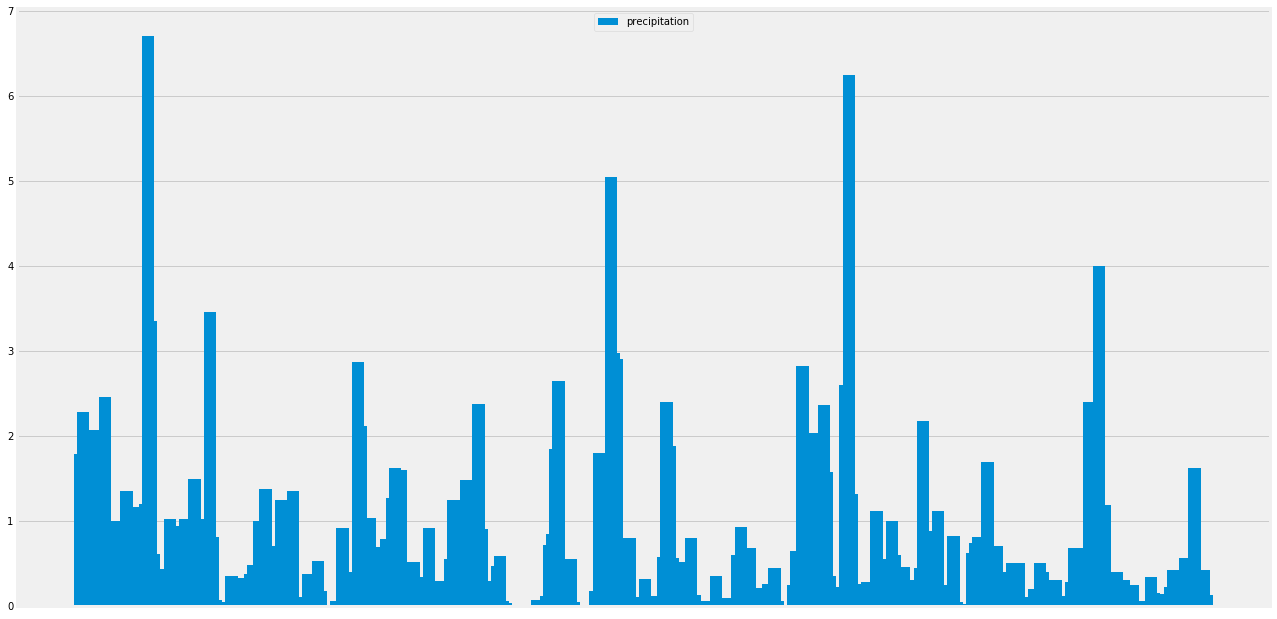

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
precipication_df = pd.read_sql_query(year_range_query.statement, engine, index_col='date')

dates = list(precipication_df.index)
fig = plt.gcf()
fig.set_size_inches(20, 11)
plt.grid(True)
plt.bar(dates, precipication_df['prcp'], width= 4, label="precipitation")
plt.legend(loc="upper center")
plt.xticks([])
plt.show()

In [15]:
# precipication_df = pd.read_sql_query(year_range_query.statement, engine, index_col='date')
# precp_plot = precipication_df.plot.bar(grid=True)
# # plt.ylim(0, 8)
# plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipication_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?

# Query the count of station ids within the "station" table
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

"""
This query displays the station and count of measurement ids for each station
To do this, this query selects the Measurement.station and func.count(Measurement.id) from the "measurement" table...
grouped by stations in the Measurement.station column... 
ordered by the count of measurement ids in descending order 
"""

session.query(Measurement.station, func.count(Measurement.id)).\
                       group_by(Measurement.station).\
                                   order_by(func.count(Measurement.id).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?

"""
Building on the previous query, this query displays the min, max, and avg temperature per station
based on values grouped by station ... ordered by measurement id count

conceptually you hold the same grouping of table values from the previous query (i.e the func.count(Measurement.id) column
still exists), but you select and display different aggreates and order these aggregates based on count
"""
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                       group_by(Measurement.station).\
                                   order_by(func.count(Measurement.id).desc()).first()

(54.0, 85.0, 71.66378066378067)

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 

#create a variable that will hold the tuple with the name of the station with the most observations
#to obtain this tuple we can reference the query used to order stations by most obseravtions 
#simply select the Measurement.station in the first row (which corresponds to the station with the most obeservations)
mobs_station = session.query(Measurement.station).\
                       group_by(Measurement.station).\
                                   order_by(func.count(Measurement.id).desc()).first()


#create a variable that will hold the date for the station with the most 
# Note the mobs_latest_date variable is currently a tuple with one item (a date string)
mobs_latest_date = session.query(Measurement.date).filter(Measurement.station == mobs_station[0]).\
                    order_by(Measurement.date.desc()).first()

#using a datetime class method we can transform our date string into a date object which allows us to better manipulate dates values
# without being forced to hard-code 
mobs_latest_date_obj = dt.date.fromisoformat(mobs_latest_date[0])

#use timedelta method plus operations to create a date object referencing a year from latest date
yrfrm_latest_mobs_date = mobs_latest_date_obj - dt.timedelta(days=365)


"""
This query selects every column within the "measurement table"... where the Measurement.station column matches 
the string representation of our station with the most observations (i.e mobs_station([0]))
... this query additionally filters the selected results for Measurement.date values falling between the latest date and
a year prior from the latest date (for the station with the most observations)
"""
mobs_station_yr_range_query = session.query(Measurement).\
               filter(Measurement.station == mobs_station[0]).\
                              filter(Measurement.date.between(str(yrfrm_latest_mobs_date), str(mobs_latest_date_obj)))



mobs_station_df = pd.read_sql(mobs_station_yr_range_query.statement, engine)
mobs_station_df.head()

,id,station,date,prcp,tobs
0,14603,USC00519281,2016-08-18,0.00,80.0
1,14604,USC00519281,2016-08-19,0.31,79.0
2,14605,USC00519281,2016-08-20,0.13,81.0
3,14606,USC00519281,2016-08-21,0.08,79.0
4,14607,USC00519281,2016-08-22,2.32,78.0


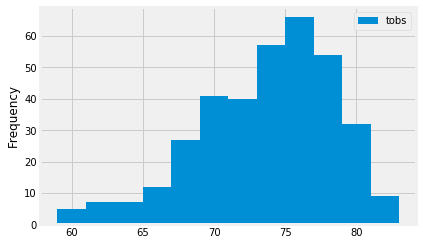

In [21]:
# plot the results as a histogram
mobs_station_df.hist(column= 'tobs', bins=12, grid=True, label="tobs")
plt.ylabel('Frequency')
plt.title('')
plt.legend(loc="best")

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

""" TRIP DATA:
Provided I have a trip start date of "2017-01-01" and an end date of "2017-01-07"
The minimum, average, and maximum temperature would be: """

trip_temps = calc_temps("2017-01-01", "2017-01-07")
trip_temps

[(62.0, 68.36585365853658, 74.0)]

In [24]:
# # Plot the results from your previous query as a bar chart. 
# # Use "Trip Avg Temp" as your Title
# # Use the average temperature for the y value
# # Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# # mintemp = trip_temps[0][0]
# # maxtemp = trip_temps[0][2]

# error = np.std(temp_list)
# plt.bar([''], trip_temps[0][1], width=0.05, yerr=error)
# plt.yticks([0, 20, 40, 60, 80, 100])
# # # plt.xticks([0, 1])
# # plt.xlim(0, 0.25)
# # plt.title('Trip Avg Temp')

# plt.show()

In [26]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


""" 
Provided I have a trip start date of "2017-01-01" and an end date of "2017-01-07"
The amount of rainfall(precipitation) per station would be: 
"""

# This query displays stations and sum of precipitation from each station
"""
To do this, this query selects Measurement.station and func.sum(Measurement.prcp) from the "measurement" table ...
where Measurement.date values fall between the start and end date for my trip...
this query additionally groups the results by station
then orders the groupings by precipitation summation values in descending order.
"""

session.query(Measurement.station, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= "2017-01-01").filter(Measurement.date <= "2017-01-07").\
               group_by(Measurement.station).\
                       order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00519523', 0.61),
 ('USC00514830', 0.6),
 ('USC00516128', 0.6),
 ('USC00513117', 0.35),
 ('USC00519281', 0.2),
 ('USC00519397', 0.0)]

## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# Set the start and end date of the trip
start = "2017-01-01"
end = "2017-01-07"

# Use the start and end date to create unique range of dates

# Typecast a numpy range of dates into a list of numpy datetimes
# Note we set the end of the range to one day further than our end date... 
# because the upperbound of numpy arange is not included
np_dates = list(np.arange(start, '2017-01-08', dtype='datetime64[D]'))

# using np.datetime_as_string method, convert list of numpy datetimes into a list of date strings
uniq_date_lst = list(np.datetime_as_string(np_dates))

# Stip off the year and save a list of %m-%d strings:

# select parsed dates from the date column based on dates falling between our start and end dates
date_partial = session.query(func.strftime("%m-%d", Measurement.date)).filter(Measurement.date.between(start, end)).all()

# Create a unique list of partial dates 
"""
Using this unique list of partial dates allows us to acquire a unique collection of normals for each %m-%d (month - day)
"""
uniq_date_prts = []
for date in date_partial:
    if date[0] not in uniq_date_prts:
        uniq_date_prts.append(date[0])
    

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in uniq_date_prts:
    normals.append(daily_normals(date)[0])

normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

""" 
Designed a query that builds on the "return" of the daily_normals function

Note:
This query selects the minimum, average, and maximum temperature observations from the Measurement table...
where the month and date ("%m-%d") portion of the strings contained within the Measurement.date column match strings
contained within our uniq_dates list ...
This query then groups the resulting aggregate results by month and date ("%m-%d" )
This essentially gives you rows which correspond to results for every unique date value passed into the daily_normals function


"""



sel2 = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

# Note: "*sel2" <----- this notation allows you to reference every element of a list
daily_normal_query = session.query(*sel2).filter(func.strftime("%m-%d", Measurement.date).in_(uniq_date_prts)).\
             group_by(func.strftime("%m-%d", Measurement.date))

#create a daily normal dataframe using pandas read_sql()
daily_normal_df = pd.read_sql(daily_normal_query.statement, engine, index_col='date')

daily_normal_df

,min_1,avg_1,max_1
date,,,
2011-01-01,62.0,69.153846,77.0
2014-01-02,60.0,69.396226,77.0
2010-01-03,62.0,68.909091,77.0
2010-01-04,58.0,70.000000,76.0
2010-01-05,56.0,67.964286,76.0
2010-01-06,61.0,68.964912,76.0
2016-01-07,57.0,68.543860,76.0


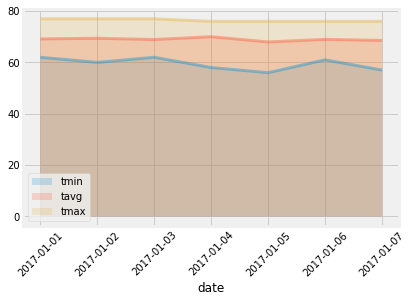

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
x = uniq_date_lst
plt.plot(x, daily_normal_df['min_1'], lw=3, alpha=0.4, label= '')
plt.plot(x, daily_normal_df['avg_1'], lw=3, alpha=0.4, label= '')
plt.plot(x, daily_normal_df['max_1'], lw=3, alpha=0.4, label= '')

plt.fill_between(x, daily_normal_df['min_1'], alpha=0.2, label='tmin')
plt.fill_between(x, daily_normal_df['avg_1'], alpha=0.2, label='tavg')
plt.fill_between(x, daily_normal_df['max_1'], alpha=0.2, label='tmax')

plt.xticks(rotation=45)
plt.yticks([0, 20, 40, 60, 80])
plt.xlabel('date')
plt.legend(loc="best")

In [33]:
year_tobs_query = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                              filter(Measurement.date.between(str(year_ago_from_latest), str(latest_date_obj))).all()
year_tobs_query

[('USC00519397', '2016-08-23', 81.0),
 ('USC00519397', '2016-08-24', 79.0),
 ('USC00519397', '2016-08-25', 80.0),
 ('USC00519397', '2016-08-26', 79.0),
 ('USC00519397', '2016-08-27', 77.0),
 ('USC00519397', '2016-08-28', 78.0),
 ('USC00519397', '2016-08-29', 78.0),
 ('USC00519397', '2016-08-30', 79.0),
 ('USC00519397', '2016-08-31', 80.0),
 ('USC00519397', '2016-09-01', 81.0),
 ('USC00519397', '2016-09-02', 80.0),
 ('USC00519397', '2016-09-03', 79.0),
 ('USC00519397', '2016-09-04', 75.0),
 ('USC00519397', '2016-09-05', 79.0),
 ('USC00519397', '2016-09-06', 76.0),
 ('USC00519397', '2016-09-07', 76.0),
 ('USC00519397', '2016-09-08', 80.0),
 ('USC00519397', '2016-09-09', 79.0),
 ('USC00519397', '2016-09-10', 78.0),
 ('USC00519397', '2016-09-11', 76.0),
 ('USC00519397', '2016-09-12', 78.0),
 ('USC00519397', '2016-09-13', 78.0),
 ('USC00519397', '2016-09-14', 75.0),
 ('USC00519397', '2016-09-15', 79.0),
 ('USC00519397', '2016-09-16', 80.0),
 ('USC00519397', '2016-09-17', 79.0),
 ('USC005193

In [38]:
stations_tup_list = session.query(Station.station).all()

In [39]:
stations_tup_list

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [41]:
# This query creates a distinct list of date tuples from our "measurement" table
distinct_dates = session.query(Measurement.date).\
    filter(Measurement.date >= earliest_date[0]).filter(Measurement.date <= latest_date[0]).distinct()

# Create an empty list that will hold date strings 
distinct_dates_list = []

# Use a "for loop" to create a list of unique date strings
# for each tuple in distinct_dates append the first element (i.e the date string) to our distinct_dates_list
for tup in distinct_dates:
    distinct_dates_list.append(tup[0])
    

In [42]:
distinct_dates_list

['2010-01-01',
 '2010-01-02',
 '2010-01-03',
 '2010-01-04',
 '2010-01-06',
 '2010-01-07',
 '2010-01-08',
 '2010-01-09',
 '2010-01-10',
 '2010-01-11',
 '2010-01-12',
 '2010-01-14',
 '2010-01-15',
 '2010-01-16',
 '2010-01-17',
 '2010-01-18',
 '2010-01-19',
 '2010-01-20',
 '2010-01-21',
 '2010-01-22',
 '2010-01-23',
 '2010-01-24',
 '2010-01-25',
 '2010-01-26',
 '2010-01-27',
 '2010-01-28',
 '2010-01-30',
 '2010-01-31',
 '2010-02-01',
 '2010-02-03',
 '2010-02-04',
 '2010-02-05',
 '2010-02-06',
 '2010-02-07',
 '2010-02-08',
 '2010-02-09',
 '2010-02-11',
 '2010-02-12',
 '2010-02-13',
 '2010-02-14',
 '2010-02-15',
 '2010-02-16',
 '2010-02-17',
 '2010-02-19',
 '2010-02-20',
 '2010-02-21',
 '2010-02-22',
 '2010-02-23',
 '2010-02-24',
 '2010-02-25',
 '2010-02-26',
 '2010-02-28',
 '2010-03-01',
 '2010-03-02',
 '2010-03-03',
 '2010-03-04',
 '2010-03-05',
 '2010-03-06',
 '2010-03-07',
 '2010-03-08',
 '2010-03-09',
 '2010-03-11',
 '2010-03-12',
 '2010-03-13',
 '2010-03-14',
 '2010-03-15',
 '2010-03-

In [ ]:
@app.route("/api/v1.0/<start>")
def start(start):
    if start in distinct_dates_list:
        temp_data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).all()
        return jsonify(temp_data)

In [ ]:
def tester(st):
    temp_data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= st).all()
    return temp_data

@app.route("/api/v1.0/<start>")
def start(start):
        return jsonify(tester(start))

In [ ]:
temp_data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= st).all()

In [ ]:
    {"superhero": "Aquaman", "real_name": "Arthur Curry"},
    {"superhero": "Batman", "real_name": "Bruce Wayne"},
    {"superhero": "Cyborg", "real_name": "Victor Stone"},
    {"superhero": "Flash", "real_name": "Barry Allen"},
    {"superhero": "Green Lantern", "real_name": "Hal Jordan"},
    {"superhero": "Superman", "real_name": "Clark Kent/Kal-El"},
    {"superhero": "Wonder Woman", "real_name": "Princess Diana"}

In [ ]:
for i in ....:
    lister.append({"station": , " ": , " ": })

In [ ]:
station_pre_dict = {}
for station in stations_list:
    query = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date.between(str(year_ago_from_latest), str(latest_date_obj))).\
                     filter(Measurement.station == station).all()
    precipitation_dict = {}
    for row in query:
        precipitation_dict[row[0]] = row[1]
    station_pre_dict[station] = precipitation_dict

    

In [ ]:
"USC00511918"

In [43]:
query = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date.between(str(year_ago_from_latest), str(latest_date_obj))).\
                     filter(Measurement.station == "USC00511918").all()

In [44]:
query

[]

In [47]:
df = pd.read_sql_table("measurement", engine)
df.loc[(df['station'] == "USC00511918" and df['date'] >= "2016-08-23")]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# This query creates a list of tuples containing (<station name>, <date>, <temperature observation>) for dates within a 
# year prior to last date data point.


year_tobs_query = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                              filter(Measurement.date.between(str(year_ago_from_latest), str(latest_date_obj))).all()



@app.route("/api/v1.0/tobs")
def tobs():

# Return a jsonified list of tuples containing (<station name>, <date>, <temperature observation>) for a year from the last data point
    return jsonify(year_tobs_query)


In [48]:
temperature_dict = {}
for station in stations_list:
    query = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date.between(str(year_ago_from_latest), str(latest_date_obj))).\
                    filter(Measurement.station == station).all()
    temperature_dict[station] = query
    

[('USC00519397', '2016-08-23', 81.0),
 ('USC00519397', '2016-08-24', 79.0),
 ('USC00519397', '2016-08-25', 80.0),
 ('USC00519397', '2016-08-26', 79.0),
 ('USC00519397', '2016-08-27', 77.0),
 ('USC00519397', '2016-08-28', 78.0),
 ('USC00519397', '2016-08-29', 78.0),
 ('USC00519397', '2016-08-30', 79.0),
 ('USC00519397', '2016-08-31', 80.0),
 ('USC00519397', '2016-09-01', 81.0),
 ('USC00519397', '2016-09-02', 80.0),
 ('USC00519397', '2016-09-03', 79.0),
 ('USC00519397', '2016-09-04', 75.0),
 ('USC00519397', '2016-09-05', 79.0),
 ('USC00519397', '2016-09-06', 76.0),
 ('USC00519397', '2016-09-07', 76.0),
 ('USC00519397', '2016-09-08', 80.0),
 ('USC00519397', '2016-09-09', 79.0),
 ('USC00519397', '2016-09-10', 78.0),
 ('USC00519397', '2016-09-11', 76.0),
 ('USC00519397', '2016-09-12', 78.0),
 ('USC00519397', '2016-09-13', 78.0),
 ('USC00519397', '2016-09-14', 75.0),
 ('USC00519397', '2016-09-15', 79.0),
 ('USC00519397', '2016-09-16', 80.0),
 ('USC00519397', '2016-09-17', 79.0),
 ('USC005193

In [50]:
query = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date.between(str(year_ago_from_latest), str(latest_date_obj))).\
                    filter(Measurement.station ==  "USC00513117").all()
query

[('2016-08-23', 76.0),
 ('2016-08-24', 76.0),
 ('2016-08-25', 77.0),
 ('2016-08-26', 78.0),
 ('2016-08-27', 73.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 76.0),
 ('2016-08-31', 77.0),
 ('2016-09-01', 79.0),
 ('2016-09-02', 78.0),
 ('2016-09-03', 77.0),
 ('2016-09-04', 75.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 74.0),
 ('2016-09-07', 75.0),
 ('2016-09-08', 77.0),
 ('2016-09-09', 76.0),
 ('2016-09-10', 76.0),
 ('2016-09-11', 76.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 76.0),
 ('2016-09-14', 76.0),
 ('2016-09-15', 78.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 78.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 75.0),
 ('2016-09-20', 78.0),
 ('2016-09-21', 76.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 76.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 77.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 77.0),
 ('2016-09-28', 77.0),
 ('2016-09-29', 76.0),
 ('2016-09-30', 77.0),
 ('2016-10-01', 75.0),
 ('2016-10-02', 77.0),
 ('2016-10-03', 78.0),
 ('2016-10-04', 78.0),
 ('2016-10-